# CSCI 3202, Spring 2022


# Lecture 13: Hill climbing Notebook Solutions

Before we begin, let's load a few packages that we might find useful.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

<br>

<img src="http://1.bp.blogspot.com/-mWUxSF7q_JY/Vbd84OcwaSI/AAAAAAAA7No/5iT8gMZBHw8/s1600/seilschaft2---helliventures-joachimhellinger.jpg=" width="300"/>



## Problem 1: Hill-climbing

The over-arching goal here is to maximize some objective function.  You can also look at this as minimizing some kind of a loss... and you will!

In many applications, the objective function might turn out to be a Gaussian function, such as this one:

In [5]:
def gaussian_objective(state):
    return stats.norm.pdf(x=state, loc=5, scale=2)

Note the this objective function is just taking in some value $\texttt{state}$ and returning the value of the normal probability density function, centered at $\texttt{loc} = \mu = 5$ and with standard deviation $\texttt{scale} = \sigma = 2$:
$$f(\texttt{state}) = \dfrac{1}{\sqrt{2\pi}\sigma} e^{-\dfrac{(\texttt{state}-\mu)^2}{2\sigma^2}}$$

For good measure, let's plot this thing up and see what it looks like.

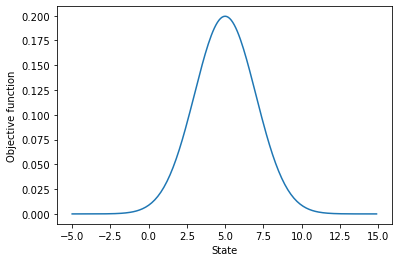

In [6]:
x = np.arange(-5,15,0.1)
f = [gaussian_objective(state) for state in x]

plt.plot(x,f)
plt.xlabel('State')
plt.ylabel('Objective function')
plt.show()

Neat.

<br>

The first order of business if we want to maximize some objective function using the **local search** techniques we just learned will be to set up a class structure to make this easier.

If we do this in a general enough way for **hill-climbing** (this first part), we will only need to modify a few things to tackle a trickier problem using **simulated annealing**.



### (1a)  A class structure to solve problems

So first, let's define a class to keep track of the `state`.  This is the quantity we want to adjust in order to optimize the objective function.  That sentence indicates the two values we really need to keep track of for a `state`:
1. the value of `state`
2. the value of the `objective_function` when evaluated at `state`

In [7]:
class state:

    def __init__(self, node, value):
        self.node = node
        self.value = value    

Now we need to define our problem.  This should be entirely self-contained, so that we need to feed the `hill_climb` optimization routine below a fairly generic problem description, and it can solve it, so we can easily feed in different problems.

**The goal** with this class structure is to have everything that is **problem-specific** sent into the hill-climbing optimization/local search be self-contained within the `problem` object.

In [8]:
class problem:
    
    def __init__(self, initial, objective_function, stepsize):
        self.initial_state = initial
        self.current_state = initial
        self.objective_function = objective_function
        self.stepsize = stepsize
        
    def moves(self):
        '''return all possible moves to make from the current_state'''
        all_moves = []
        # could move right...
        all_moves.append(self.current_state.node + self.stepsize)
        # ... or left!
        all_moves.append(self.current_state.node - self.stepsize)
        return all_moves

Finally, we can turn our Hill-climbing pseudocode into real code, that takes only two arguments and returns the `state` that optimizes the `objective_function`.  Note that the return can be done implicitly by manipulating the current state within our `problem`, or we could code it up as an explicit output.

In [9]:
def hill_climb(problem, n_iter):
    
    # iterate until we can't do any better
    for k in range(n_iter):
        nextMove, nextValue = problem.best_move()
        if nextValue <= problem.current_state.value:
            return problem.current_state
        #print(problem.current_state, nextMove)
        problem.current_state.node, problem.current_state.value = nextMove, nextValue
    print('reached n_iter')
    return False

class problem_hillclimb(problem):
    
    def best_move(self):
        '''return the best move possible from the current_state'''
        # what moves are possible?
        all_moves = self.moves()
        # what is objective function for each of them?
        obj_func = [self.objective_function(move) for move in all_moves]
        best = all_moves[max(zip(obj_func, range(len(obj_func))))[1]]
        return best, np.max(obj_func)



### (1b)  Ready to solve!

Let's start by creating an `initial_state` for our problem.

In [10]:
initial_state = state(node=1, value=gaussian_objective(1))

Now we need an instance of our `problem`.

In [11]:
gaussian_problem = problem_hillclimb(initial=initial_state, objective_function=gaussian_objective, stepsize=0.1)

Finally, we can turn out `hill_climb` algorithm loose on this problem.

In [12]:
out = hill_climb(gaussian_problem, n_iter=50)
print(out.node, out.value)

40
4.999999999999999 0.19947114020071635


## A couple extensions

That's good and all, but that particular objective function was just a single univariate Gaussian.  It turns out that the real world is tougher than that.  So let's tackle some tougher problems, shall we?



### (1c) Minimization

First, it might be the case that we want to ***minimize*** an objective function instead of maximizing it.  Modify your hill-climbing codes to tackle the problem of minimization.  Note:  this ought to be do-able by modifying a single line of code from above...

Now **define your own** objective function to minimize!  Easy options include concave-up quadratic functions just slapping a $-$ sign into the Gaussian objective function defined above.  Then turn your descent algorithm loose on the minimization problem.


### (1d)  Random restarts

That single Gaussian actually covers many real-world applications of optimization and local search, but many other applications lead to "bumpier" objective functions.  Suppose you are trying to fit a model to noisy data, and suppose each of your data points has normally-distributed uncertainty.  Then the objective function you would like to minimize could take the form of the sum of several Gaussian distributions, like so:

$$f(\texttt{state}) = \dfrac{1}{\sqrt{2\pi}\sigma} \left(e^{-\dfrac{(\texttt{state}-\mu_0)^2}{2\sigma^2}} + 
e^{-\dfrac{(\texttt{state}-\mu_1)^2}{2\sigma^2}} + 
e^{-\dfrac{(\texttt{state}-\mu_2)^2}{2\sigma^2}} + 
e^{-\dfrac{(\texttt{state}-\mu_3)^2}{2\sigma^2}} + 
e^{-\dfrac{(\texttt{state}-\mu_4)^2}{2\sigma^2}}\right)$$

Here, $\mu_i$ denotes the data points you have, $\sigma$ is assumed to be an uncertainty shared by all of them, and $\texttt{state}$ is your model's output, which you want to fit through those data points.

If we let $\sigma=1$, $\mu_0 = 0$, $\mu_1 = 2.1$, $\mu_2 = 4$, $\mu_3 = 4$ and $\mu_4 = 8$, then we end up with the following objective function, `several_gaussian_objective(state)`:

In [10]:
def several_gaussian_objective(state):
    locs = [0,2.1,4,4,8] # centers of a bunch of normal distributions
    objective_value = 0
    # objective function is actually just the sum of a bunch of normal pdfs
    for loc in locs:
        objective_value += stats.norm.pdf(state, loc=loc, scale=1)
    return objective_value

Plot up this new objective function as a function of `state`.  What do you notice?  Will our "vanilla" hill-climbing routine successfully climb the hill and maximize this objective function for *any* initial state?

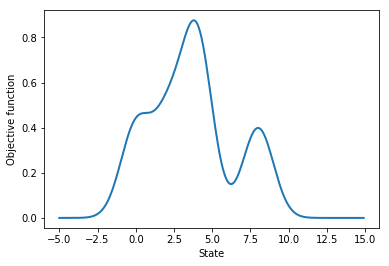

In [11]:
x = np.arange(start=-5, stop=15, step=0.1)
fx = [several_gaussian_objective(xk) for xk in x]
plt.plot(x, fx, lw=2)
plt.xlabel('State')
plt.ylabel('Objective function')
plt.show()

Note that we can check about where the global maximum is fairly easily:

In [12]:
max(zip(fx, x))

(0.8764853553213469, 3.7999999999999687)

Let's modify our vanilla hill-climbing solution approach from **(1b)** to include 500 random restarts for the initial state.

The following code will draw `n_restarts` random samples from the range $[0, 1)$.

In [13]:
n_restarts = 500
sample = np.random.random(size=n_restarts)

Modify that to draw instead from the range $[-2, 10)$.  Use those samples to create an **ensemble** of the values of `state` for which the objective function is maximized.  Plot a histogram of them, and make a conclusion about what the "best guess" for the maximal `state` is.

[ 1.37435384 -1.35858295  3.5858479   7.35394628  0.07224809  8.95821321
  9.75396944  9.30893339  3.22825958  6.36151844]


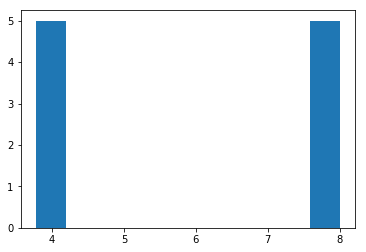

In [14]:
n_restarts = 10
max_found = []
range_init = [-2, 10]
initial_values = np.random.random(size=n_restarts)*np.diff(range_init)+range_init[0]
#initial_values = np.random.uniform(-2,10,size=n_restarts)
print(initial_values)

for n in range(n_restarts):
    initial_state = state(node=initial_values[n], value=several_gaussian_objective(initial_values[n]))
    gaussian_problem = problem_hillclimb(initial=initial_state, objective_function=several_gaussian_objective, stepsize=0.1)
    out = hill_climb(gaussian_problem, n_iter=500)
    max_found.append(out.node)
    
plt.hist(max_found)
plt.show()